In [1]:
# 1. Import libraries:
%matplotlib inline
import os
import quandl
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
from scipy.stats import kurtosis, skew
import seaborn as sns
# from financial_data import *
import tensorflow as tf
mlp.style.use('seaborn')
quandl.save_key('HtwBLPt3k37yZHTvy15K')

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13053/4242266090.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mlp.style.use('seaborn')


In [2]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(sp_url, header=0)[0]
sp500.head()



,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
# Correct invalid dates:
sp500.loc[sp500[sp500['Date added']=='1983-11-30 (1957-03-04)'].index,'Date added'] = '1983-11-30'
sp500.loc[sp500[sp500['Date added']=='2001?'].index,'Date added'] = '2001-01-01'
# Filter firms that entered the index after December 2015:
sp500['Date added'] = pd.to_datetime(sp500['Date added'],format='%Y-%m-%d')
sp500 = sp500[sp500['Date added']<'2007-01-01']
print("The number of stocks in the universe is:", sp500.shape[0])

The number of stocks in the universe is: 241


In [4]:
n_stocks = 2
np.random.seed(1792)
universe_tickers = sp500['Symbol'].unique()
tickers = list(np.random.choice(universe_tickers,replace=False,size=n_stocks))
print(tickers)
# sp500[sp500['Symbol'].isin(portfolio_tickers)]

['DIS', 'BIIB']


In [5]:
# tickers = ['AAPL', 'GOOGL', 'MSFT','SPY']
# start_date='2007-01-01'
# end_date='2022-12-31'
# columns = ['Adj Close', 'Volume']
# # Download data
# data = yf.download(tickers, start=start_date, end=end_date)[columns]

# # 'data' will be a Pandas DataFrame containing the historical data for the specified tickers
# print(data)


def download_data(tickers, start_date, end_date, columns):
    data = yf.download(tickers, start=start_date, end=end_date)
    data=data[columns]
    return data

# Define the tickers, start date, end date, and columns you want to download
# tickers = ['AAPL', 'GOOGL', 'MSFT']
start_date = '2007-01-01'
end_date = '2022-12-31'
columns = [ 'Adj Close', 'Volume','Open','High','Low']

# Download the data
data = download_data(tickers, start_date, end_date, columns)
# print(data)


def one_lvl_colnames(df,cols,tickers):
    """This function changes a multi-level column indexation into a one level
    column indexation

    Inputs:
    -------
    df (pandas Dataframe): dataframe with the columns whose indexation will be 
        flattened.
    tickers (list|string): list/string with the tickers (s) in the data frame df.
    cols (list|string): list/string with the name of the columns (e.g. 'Adj Close',
        'High', 'Close', etc.) that are in the dataframe df.
    
    Ouputs:
    -------
    df (pandas Dataframe): dataframe with the same information as df, but 
        with one level of indexation.
    """
    
    
#     print("the dataframe before the columns were renamed")
#     print(df.columns)
    df_not_renamed=df.copy()
#     df_not_renamed.drop("Open",inplace=True)
#     print(df_not_renamed.columns)
    # Define important variables:
    if isinstance(tickers, str):
        tickers = [tickers]
    if isinstance(cols, str):
        
        cols = [cols]
#         print(cols)

    # For multi-level column indexing:
    if isinstance(df.columns.values[0], tuple):

        # Define important varibles
        columns = df.columns.values
        new_cols = []

        # Itarate through the multi-level column names and flatten them:
        for col in columns:
            temp = []
            for name in col:
                if name != '':
                    temp.append(name)
            new_temp = '_'.join(temp)
            new_cols.append(new_temp)
        
        # Change the column names:
        df.columns = new_cols
#         print(df.columns)
    
    # For uni-level colum indexing:
    elif isinstance(df.columns.values[0], str):
        
        # Define new names:
        col_names = [column+'_'+ticker for column in cols\
                     for ticker in tickers]
        df.columns = col_names
    
#     print("the dataframe after the columns have been renamed") 
#     print(df)

    return df

df2=pd.DataFrame(one_lvl_colnames(data,cols=columns,tickers=tickers))
df2_columns=list(df2.columns)
df2.columns = [col.replace('Adj Close', 'Close') for col in df2_columns]
df2.fillna(method='ffill',inplace=True)
df2.fillna(method='bfill',inplace=True)
df2

[*********************100%%**********************]  2 of 2 completed


,Close_BIIB,Close_DIS,Volume_BIIB,Volume_DIS,Open_BIIB,Open_DIS,High_BIIB,High_DIS,Low_BIIB,Low_DIS
Date,,,,,,,,,,
2007-01-03,49.330002,28.317091,3833500,13562595,49.279999,33.748165,50.250000,34.073711,48.200001,33.531136
2007-01-04,49.750000,28.540653,2884300,9806285,49.270000,33.738300,50.099998,34.083576,48.880001,33.708706
2007-01-05,49.759998,28.308813,2230400,10551445,49.990002,33.807354,50.330002,33.975060,49.509998,33.531136
2007-01-08,50.020000,28.565491,3160200,9479676,50.000000,33.728436,50.160000,34.162495,48.910000,33.610054
2007-01-09,49.500000,28.524088,2816500,11588444,49.880001,34.034248,50.139999,34.221684,49.299999,33.491676
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,279.160004,88.010002,624800,11171600,280.450012,86.059998,280.450012,88.070000,276.070007,85.769997
2022-12-27,274.769989,86.370003,638600,11561400,279.890015,87.419998,279.890015,87.940002,273.380005,85.959999
2022-12-28,274.040009,84.169998,521000,12399500,275.640015,86.080002,276.920013,86.690002,272.640015,84.070000


In [6]:
pd.set_option('display.max_rows', 100)

In [7]:
from stockstats import StockDataFrame
def extract_and_wrap_ticker_data(df, columns):
    # Split column names into parts
    parts = [col.split('_') for col in columns]

    # Create a dictionary to store information about each ticker
    ticker_info = {}

    # Iterate through the parts list
    for part in parts:
        data_type = part[0]  # e.g., 'Adj Close', 'Close', etc.
        ticker = part[1]     # e.g., 'AAPL', 'GOOGL', etc.

        # Check if the ticker is already in the dictionary
        if ticker not in ticker_info:
            ticker_info[ticker] = {}

        # Add information for the ticker
        ticker_info[ticker][data_type] = df[f'{data_type}_{ticker}']

    # Create a dictionary to store stockstats DataFrames for each ticker
    ticker_dataframes = pd.DataFrame()
#     var_importance_all=

    # Iterate through ticker_info and wrap data with stockstats
    for ticker, data in ticker_info.items():
#         print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        df = pd.DataFrame(data)
        print(ticker)
#         print(df)
        
        stock_df = StockDataFrame.retype(df)
#         print(stock_df)

        stock_df.init_all()
        
#         print("&&&&&&&&&&&&&&&&&&&&&&&&")
#         
#         stock_df['close']=stock_df['rate']
#         stock_df.drop(columns=['rate'],inplace=True)
        print(stock_df.columns)
        stock_df.columns = [ticker+"_" + col for col in pd.DataFrame(stock_df).columns]
        ticker_dataframes = pd.concat([ticker_dataframes,stock_df],axis=1)
        
    return ticker_dataframes

# Sample DataFrame with specified columns
columns = list(df2.columns)
# print(columns)



# Extract and wrap ticker data
ticker_dataframes = extract_and_wrap_ticker_data(df2, columns)

# Access information for a specific ticker (e.g., AAPL)
# print(ticker_dataframes)

ticker_dataframes

BIIB
Index(['close', 'volume', 'open', 'high', 'low', 'rate', 'middle', 'tp',
       'boll', 'boll_ub', 'boll_lb', 'macd', 'macds', 'macdh', 'pvo', 'pvos',
       'pvoh', 'ppo', 'ppos', 'ppoh', 'qqe', 'qqel', 'qqes', 'cr', 'cr-ma1',
       'cr-ma2', 'cr-ma3', 'tr', 'dx', 'adx', 'adxr', 'log-ret', 'wt1', 'wt2',
       'supertrend_ub', 'supertrend_lb', 'supertrend', 'bop', 'cti', 'eribull',
       'eribear', 'rvgi', 'rvgis', 'kst', 'ao', 'aroon', 'atr', 'cci',
       'change', 'chop', 'cmo', 'coppock', 'dma', 'ichimoku', 'inertia', 'ftr',
       'kama', 'kdjk', 'kdjd', 'kdjj', 'ker', 'mfi', 'ndi', 'pdi', 'pgo',
       'psl', 'rsi', 'rsv', 'stochrsi', 'tema', 'trix', 'wr', 'vr', 'vwma'],
      dtype='object')
DIS
Index(['close', 'volume', 'open', 'high', 'low', 'rate', 'middle', 'tp',
       'boll', 'boll_ub', 'boll_lb', 'macd', 'macds', 'macdh', 'pvo', 'pvos',
       'pvoh', 'ppo', 'ppos', 'ppoh', 'qqe', 'qqel', 'qqes', 'cr', 'cr-ma1',
       'cr-ma2', 'cr-ma3', 'tr', 'dx', 'adx', 'adxr'

,BIIB_close,BIIB_volume,BIIB_open,BIIB_high,BIIB_low,BIIB_rate,BIIB_middle,BIIB_tp,BIIB_boll,BIIB_boll_ub,...,DIS_pgo,DIS_psl,DIS_rsi,DIS_rsv,DIS_stochrsi,DIS_tema,DIS_trix,DIS_wr,DIS_vr,DIS_vwma
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,49.330002,3833500,49.279999,50.250000,48.200001,NaN,49.260001,49.260001,49.330002,NaN,...,0.000000,0.000000,NaN,-960.979871,NaN,28.317091,0.000000,-1060.979871,100.000000,31.973979
2007-01-04,49.750000,2884300,49.270000,50.099998,48.880001,0.851405,49.576667,49.576667,49.540001,50.133968,...,0.019400,8.333333,100.000000,-903.351770,NaN,28.526345,0.125472,-1003.351770,244.607798,32.031468
2007-01-05,49.759998,2230400,49.990002,50.330002,49.509998,0.020097,49.866666,49.866666,49.613333,50.104180,...,-0.014199,8.333333,47.241151,-945.318294,0.000000,28.355735,0.044076,-1045.318294,95.700853,32.002498
2007-01-08,50.020000,3160200,50.000000,50.160000,48.910000,0.522512,49.696667,49.696667,49.715000,50.285963,...,0.023229,16.666667,67.613566,-786.500873,38.614215,28.514557,0.042512,-886.500873,150.393156,32.026565
2007-01-09,49.500000,2816500,49.880001,50.139999,49.299999,-1.039585,49.646666,49.646666,49.672000,50.202546,...,0.012803,16.666667,63.363342,-680.484880,30.558269,28.533565,0.041238,-780.484880,90.132051,32.037646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,279.160004,624800,280.450012,280.450012,276.070007,-0.516725,278.560008,278.560008,289.894499,303.001943,...,-0.958692,50.000000,38.946239,26.141736,44.867435,87.242870,-0.380298,-73.858264,108.064064,90.644895
2022-12-27,274.769989,638600,279.890015,279.890015,273.380005,-1.572580,276.013336,276.013336,289.037999,303.735876,...,-1.452198,41.666667,36.083085,15.584420,25.496638,86.634807,-0.405455,-86.771648,108.460616,90.268113
2022-12-28,274.040009,521000,275.640015,276.920013,272.640015,-0.265670,274.533346,274.533346,288.169499,304.263686,...,-2.071226,33.333333,32.618813,1.104955,2.058954,84.859200,-0.434257,-99.249261,97.570084,89.859419


In [8]:
len(['close', 'volume', 'open', 'high', 'low', 'middle', 'tp','rate',
       'boll', 'boll_ub', 'boll_lb', 'macd', 'macds', 'macdh', 'pvo', 'pvos',
       'pvoh', 'ppo', 'ppos', 'ppoh', 'qqe', 'qqel', 'qqes', 'cr', 'cr-ma1',
       'cr-ma2', 'cr-ma3', 'tr', 'dx', 'adx', 'adxr', 'log-ret', 'wt1', 'wt2',
       'supertrend_ub', 'supertrend_lb', 'supertrend', 'bop', 'cti', 'eribull',
       'eribear', 'rvgi', 'rvgis', 'kst', 'ao', 'aroon', 'atr', 'cci',
       'change', 'chop', 'cmo', 'coppock', 'dma', 'ichimoku', 'inertia', 'ftr',
       'kama', 'kdjk', 'kdjd', 'kdjj', 'ker', 'mfi', 'ndi', 'pdi', 'pgo',
       'psl', 'rsi', 'rsv', 'stochrsi', 'tema', 'trix', 'wr', 'vr', 'vwma'])

74

In [9]:
# Define the tickers
new_tickers = ['EIA/PET_RWTC_D','FRED/T10Y2Y','FRED/T10Y3M','FRED/DTB3','FRED/DLTIIT','FRED/TEDRATE']

# # Define the date range
# start='2020-01-01'
# end='2021-01-01'
names = ['wti_spot','10y2y_spread','10y3m_spread','3m_rate','ltiit','ted_spread']
# add_factors = quandl.get(tickers, start=start_date, end=end_date)

# # Retrieve data
data_quandl = quandl.get(new_tickers, start_date=start_date, end_date=end_date)
data_quandl.columns = names
data_quandl['var_wti'] = data_quandl['wti_spot'].pct_change()
# print(data_quandl)

# # Fill NaN values:
# data_quandl.fillna(method='ffill',inplace=True)
# data_quandl.fillna(method='bfill',inplace=True)


# # Print the data
print(data_quandl)



            wti_spot  10y2y_spread  10y3m_spread  3m_rate  ltiit  ted_spread  \
Date                                                                           
2007-01-02     60.77         -0.12         -0.39     4.94   2.33        0.42   
2007-01-03     58.31         -0.09         -0.38     4.92   2.32        0.44   
2007-01-04     55.65         -0.09         -0.42     4.91   2.30        0.45   
2007-01-05     56.29         -0.11         -0.40     4.92   2.33        0.44   
2007-01-08     56.08         -0.12         -0.42     4.95   2.34        0.41   
...              ...           ...           ...      ...    ...         ...   
2022-07-12       NaN         -0.07          0.74     2.16   1.12         NaN   
2022-07-13       NaN         -0.22          0.52     2.33   1.06         NaN   
2022-07-14       NaN         -0.19          0.56     2.33   1.07         NaN   
2022-07-15       NaN         -0.20          0.56     2.29   1.03         NaN   
2022-07-18       NaN         -0.19      

In [10]:
final_df=pd.merge(ticker_dataframes.reset_index(),data_quandl.reset_index(),on=['Date'],how='inner')

final_df[14:]

,Date,BIIB_close,BIIB_volume,BIIB_open,BIIB_high,BIIB_low,BIIB_rate,BIIB_middle,BIIB_tp,BIIB_boll,...,DIS_wr,DIS_vr,DIS_vwma,wti_spot,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
14,2007-01-24,48.790001,3545200,49.230000,49.299999,48.590000,-0.692042,48.893333,48.893333,50.280667,...,-311.890149,132.384270,32.674011,54.24,-0.12,-0.32,5.00,2.39,0.36,0.011752
15,2007-01-25,47.790001,4167600,48.500000,48.560001,47.439999,-2.049600,47.930000,47.930000,50.125000,...,-328.925576,116.887337,32.715174,53.49,-0.11,-0.27,5.01,2.43,0.35,-0.013827
16,2007-01-26,47.520000,2816400,47.740002,47.939999,47.040001,-0.564973,47.500000,47.500000,49.971765,...,-345.130575,103.563893,32.746986,55.38,-0.11,-0.25,5.00,2.44,0.36,0.035334
17,2007-01-29,47.680000,2753400,47.430000,48.009998,47.230000,0.336700,47.639999,47.639999,49.844445,...,-339.728781,115.673122,32.762709,54.01,-0.09,-0.24,5.01,2.46,0.35,-0.024738
18,2007-01-30,48.049999,2927700,47.849998,48.209999,47.580002,0.776004,47.946667,47.946667,49.750000,...,-329.666611,122.858058,32.807756,57.03,-0.10,-0.25,5.00,2.43,0.36,0.055916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,2022-07-12,215.580002,711100,216.660004,218.559998,214.039993,0.148661,216.059998,216.059998,207.305500,...,-81.048910,47.236385,95.563882,NaN,-0.07,0.74,2.16,1.12,NaN,0.000000
3908,2022-07-13,214.529999,635100,211.919998,216.350006,211.919998,-0.487060,214.266668,214.266668,208.424000,...,-79.446215,45.980570,95.473533,NaN,-0.22,0.52,2.33,1.06,NaN,0.000000
3909,2022-07-14,214.270004,920100,212.979996,215.050003,210.259995,-0.121193,213.193334,213.193334,209.428500,...,-84.169191,45.162252,95.297480,NaN,-0.19,0.56,2.33,1.07,NaN,0.000000
3910,2022-07-15,217.009995,732100,215.369995,217.360001,213.750000,1.278756,216.039998,216.039998,210.416000,...,-51.130831,54.593156,95.051791,NaN,-0.20,0.56,2.29,1.03,NaN,0.000000


In [11]:
final_df2=final_df.copy()

for ticker in tickers:
#     final_df2[ticker+"_close"] = final_df2[ticker+"_close"].pct_change()
    final_df2.drop(columns=[ticker+"_cr",ticker+"_cr-ma1",ticker+"_cr-ma2",ticker+"_cr-ma3"],inplace=True)
    final_df2[ticker+'_close']=final_df2[ticker+'_close'].shift(-1)
    print(final_df2)
#     final_df2=final_df2.dropna(subset=[ticker+"_close",ticker+"_close_14_sma",ticker+"_close_14_roc",ticker+"_boll_ub",ticker+"_boll_lb",ticker+"_boll"])
final_df2.fillna(method='ffill',inplace=True)
final_df2.fillna(method='bfill',inplace=True)

final_df2=final_df2.loc[14:]
final_df2.set_index(['Date'],inplace=True)
final_df2.drop(columns=['wti_spot','ted_spread'],inplace=True)

final_df2

           Date  BIIB_close  BIIB_volume   BIIB_open   BIIB_high    BIIB_low  \
0    2007-01-03   49.330002      3833500   49.279999   50.250000   48.200001   
1    2007-01-04   49.750000      2884300   49.270000   50.099998   48.880001   
2    2007-01-05   49.759998      2230400   49.990002   50.330002   49.509998   
3    2007-01-08   50.020000      3160200   50.000000   50.160000   48.910000   
4    2007-01-09   49.500000      2816500   49.880001   50.139999   49.299999   
...         ...         ...          ...         ...         ...         ...   
3907 2022-07-12  215.580002       711100  216.660004  218.559998  214.039993   
3908 2022-07-13  214.529999       635100  211.919998  216.350006  211.919998   
3909 2022-07-14  214.270004       920100  212.979996  215.050003  210.259995   
3910 2022-07-15  217.009995       732100  215.369995  217.360001  213.750000   
3911 2022-07-18  214.339996      1056100  217.570007  218.789993  213.050003   

      BIIB_rate  BIIB_middle     BIIB_t

,BIIB_close,BIIB_volume,BIIB_open,BIIB_high,BIIB_low,BIIB_rate,BIIB_middle,BIIB_tp,BIIB_boll,BIIB_boll_ub,...,DIS_tema,DIS_trix,DIS_wr,DIS_vr,DIS_vwma,10y2y_spread,10y3m_spread,3m_rate,ltiit,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-24,47.790001,3545200,49.230000,49.299999,48.590000,-0.692042,48.893333,48.893333,50.280667,52.424768,...,29.313460,0.153145,-311.890149,132.384270,32.674011,-0.12,-0.32,5.00,2.39,0.011752
2007-01-25,47.520000,4167600,48.500000,48.560001,47.439999,-2.049600,47.930000,47.930000,50.125000,52.541929,...,29.035093,0.145077,-328.925576,116.887337,32.715174,-0.11,-0.27,5.01,2.43,-0.013827
2007-01-26,47.680000,2816400,47.740002,47.939999,47.040001,-0.564973,47.500000,47.500000,49.971765,52.631306,...,28.690341,0.127591,-345.130575,103.563893,32.746986,-0.11,-0.25,5.00,2.44,0.035334
2007-01-29,48.049999,2753400,47.430000,48.009998,47.230000,0.336700,47.639999,47.639999,49.844445,52.641630,...,28.631642,0.107384,-339.728781,115.673122,32.762709,-0.09,-0.24,5.01,2.46,-0.024738
2007-01-30,48.340000,2927700,47.849998,48.209999,47.580002,0.776004,47.946667,47.946667,49.750000,52.590329,...,28.837843,0.091026,-329.666611,122.858058,32.807756,-0.10,-0.25,5.00,2.43,0.055916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,214.529999,711100,216.660004,218.559998,214.039993,0.148661,216.059998,216.059998,207.305500,224.412286,...,93.620483,-0.354957,-81.048910,47.236385,95.563882,-0.07,0.74,2.16,1.12,0.000000
2022-07-13,214.270004,635100,211.919998,216.350006,211.919998,-0.487060,214.266668,214.266668,208.424000,224.237629,...,92.863288,-0.345133,-79.446215,45.980570,95.473533,-0.22,0.52,2.33,1.06,0.000000
2022-07-14,217.009995,920100,212.979996,215.050003,210.259995,-0.121193,213.193334,213.193334,209.428500,223.930335,...,91.854002,-0.342773,-84.169191,45.162252,95.297480,-0.19,0.56,2.33,1.07,0.000000


In [12]:
pd.DataFrame(final_df2.isnull().sum()).sort_values(by=0,ascending=False).head()

# pd.DataFrame(np.isinf(final_df2).sum()).sort_values(by=0,ascending=False).head(50)

,0
BIIB_close,0
DIS_high,0
DIS_tr,0
DIS_dx,0
DIS_adx,0


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
def check_var_importance(df,ticker):
    # Separate features (X) and target (y)
    # AAPL_df.drop(columns=["AAPL_cr"],inplace=True)
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    print("**************************")
#     print(df.isnull())

    X = df  # Use relevant columns
    y = df[ticker+'_close']  # Target variable is 'Close'

    # Standardize features (optional but often recommended for neural networks)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Create sequences of length 5 for X and corresponding y for training
    X_train, y_train = [], []

    for i in range(5, len(X)):
        X_train.append(X[i-5:i])
        y_train.append(y[i])

    X_train, y_train = np.array(X_train), np.array(y_train)
#     print(X_train)
#     print("***************")
#     print(y_train)

    # Step 2: Check Variable Importance
    # Use RandomForestRegressor to determine importance
    rf = RandomForestRegressor(n_estimators=10)
    rf.fit(X_train.reshape(-1, 5 * X.shape[1]), y_train)

    # Get feature importances along with their corresponding feature names
    feature_importances = rf.feature_importances_
    feature_names = [col.split(ticker+"_")[-1] for col in df.columns]
#     print(feature_names)

    # Combine feature names with their importances
    feature_importance_info = list(zip(feature_names, feature_importances))

    # Sort the list by importance (in descending order)
    feature_importance_info.sort(key=lambda x: x[0])

    return pd.DataFrame(feature_importance_info,columns=['Features',ticker+'_Relative_Importance'])

    

In [14]:
final_df2.head(2)
feat_importance_all=pd.DataFrame()
for ticker in tickers:

    matching_columns = [col for col in final_df2.columns if ticker in col]
#     print(matching_columns)
#     matching_columns.append([])
    # # Print matching columns
    # for col in matching_columns:
    #     print(col)

    temp_df=final_df2[matching_columns]
    feat_importance_temp=check_var_importance(temp_df,ticker)
    feat_importance_all=pd.concat([feat_importance_all,feat_importance_temp], axis=1)
#     print(feat_importance_all)
feat_importance_all=feat_importance_all.T.drop_duplicates(keep='first').T
feat_importance_all["Average_relative_Importance"]=feat_importance_all.iloc[:,1:].mean(axis=1)
print(feat_importance_all)
threshold = 1e-6 # Example threshold value

# Create a boolean mask based on the condition
mask = feat_importance_all['Average_relative_Importance'] >= threshold

# Apply the mask to the DataFrame
filtered_df = feat_importance_all[mask]

# df['Average_Columns'] = df[['Column1', 'Column2']].mean(axis=1)
#     print(temp_df)

filtered_df.reset_index(drop=True,inplace=True)
filtered_df

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13053/1906898070.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13053/1906898070.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bfill(inplace=True)


**************************


/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13053/1906898070.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13053/1906898070.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bfill(inplace=True)


**************************
         Features DIS_Relative_Importance BIIB_Relative_Importance  \
0             adx                0.000007                 0.000019   
1            adxr                0.000007                 0.000013   
2              ao                0.000001                 0.000004   
3           aroon                0.000003                 0.000005   
4             atr                0.000007                 0.000009   
5            boll                0.000001                 0.084616   
6         boll_lb                0.000108                 0.000006   
7         boll_ub                0.000012                 0.000009   
8             bop                0.000005                 0.000034   
9             cci                0.000001                 0.000004   
10         change                0.000002                 0.000006   
11           chop                0.000007                 0.000022   
12          close                0.000002                 0.000

,Features,DIS_Relative_Importance,BIIB_Relative_Importance,Average_relative_Importance
0,adx,0.000007,0.000019,0.000013
1,adxr,0.000007,0.000013,0.000010
2,ao,0.000001,0.000004,0.000003
3,aroon,0.000003,0.000005,0.000004
4,atr,0.000007,0.000009,0.000008
5,boll,0.000001,0.084616,0.042308
6,boll_lb,0.000108,0.000006,0.000057
7,boll_ub,0.000012,0.000009,0.000010
8,bop,0.000005,0.000034,0.000020
9,cci,0.000001,0.000004,0.000002


In [15]:
final_df2.head(2)

,BIIB_close,BIIB_volume,BIIB_open,BIIB_high,BIIB_low,BIIB_rate,BIIB_middle,BIIB_tp,BIIB_boll,BIIB_boll_ub,...,DIS_tema,DIS_trix,DIS_wr,DIS_vr,DIS_vwma,10y2y_spread,10y3m_spread,3m_rate,ltiit,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-24,47.790001,3545200,49.23,49.299999,48.590000,-0.692042,48.893333,48.893333,50.280667,52.424768,...,29.313460,0.153145,-311.890149,132.384270,32.674011,-0.12,-0.32,5.00,2.39,0.011752
2007-01-25,47.520000,4167600,48.50,48.560001,47.439999,-2.049600,47.930000,47.930000,50.125000,52.541929,...,29.035093,0.145077,-328.925576,116.887337,32.715174,-0.11,-0.27,5.01,2.43,-0.013827


In [16]:
imp_col_names=[filtered_df['Features'].values][0].tolist()

# imp_col_names = [ticker +"_"+ element for element in imp_col_names]
final_col_names = []
for col in imp_col_names:
    for ticker in tickers:
        final_col_names.append(f'{ticker}_{col}')

print(final_col_names)

['DIS_adx', 'BIIB_adx', 'DIS_adxr', 'BIIB_adxr', 'DIS_ao', 'BIIB_ao', 'DIS_aroon', 'BIIB_aroon', 'DIS_atr', 'BIIB_atr', 'DIS_boll', 'BIIB_boll', 'DIS_boll_lb', 'BIIB_boll_lb', 'DIS_boll_ub', 'BIIB_boll_ub', 'DIS_bop', 'BIIB_bop', 'DIS_cci', 'BIIB_cci', 'DIS_change', 'BIIB_change', 'DIS_chop', 'BIIB_chop', 'DIS_close', 'BIIB_close', 'DIS_cmo', 'BIIB_cmo', 'DIS_coppock', 'BIIB_coppock', 'DIS_cti', 'BIIB_cti', 'DIS_dma', 'BIIB_dma', 'DIS_dx', 'BIIB_dx', 'DIS_eribear', 'BIIB_eribear', 'DIS_eribull', 'BIIB_eribull', 'DIS_ftr', 'BIIB_ftr', 'DIS_high', 'BIIB_high', 'DIS_ichimoku', 'BIIB_ichimoku', 'DIS_inertia', 'BIIB_inertia', 'DIS_kama', 'BIIB_kama', 'DIS_kdjd', 'BIIB_kdjd', 'DIS_kdjj', 'BIIB_kdjj', 'DIS_kdjk', 'BIIB_kdjk', 'DIS_ker', 'BIIB_ker', 'DIS_kst', 'BIIB_kst', 'DIS_log-ret', 'BIIB_log-ret', 'DIS_low', 'BIIB_low', 'DIS_macdh', 'BIIB_macdh', 'DIS_macds', 'BIIB_macds', 'DIS_mfi', 'BIIB_mfi', 'DIS_middle', 'BIIB_middle', 'DIS_ndi', 'BIIB_ndi', 'DIS_open', 'BIIB_open', 'DIS_pdi', 'BIIB_

In [17]:
final_col_names=final_col_names+['10y2y_spread','10y3m_spread','3m_rate','ltiit','var_wti']

In [18]:
final_col_names

['DIS_adx',
 'BIIB_adx',
 'DIS_adxr',
 'BIIB_adxr',
 'DIS_ao',
 'BIIB_ao',
 'DIS_aroon',
 'BIIB_aroon',
 'DIS_atr',
 'BIIB_atr',
 'DIS_boll',
 'BIIB_boll',
 'DIS_boll_lb',
 'BIIB_boll_lb',
 'DIS_boll_ub',
 'BIIB_boll_ub',
 'DIS_bop',
 'BIIB_bop',
 'DIS_cci',
 'BIIB_cci',
 'DIS_change',
 'BIIB_change',
 'DIS_chop',
 'BIIB_chop',
 'DIS_close',
 'BIIB_close',
 'DIS_cmo',
 'BIIB_cmo',
 'DIS_coppock',
 'BIIB_coppock',
 'DIS_cti',
 'BIIB_cti',
 'DIS_dma',
 'BIIB_dma',
 'DIS_dx',
 'BIIB_dx',
 'DIS_eribear',
 'BIIB_eribear',
 'DIS_eribull',
 'BIIB_eribull',
 'DIS_ftr',
 'BIIB_ftr',
 'DIS_high',
 'BIIB_high',
 'DIS_ichimoku',
 'BIIB_ichimoku',
 'DIS_inertia',
 'BIIB_inertia',
 'DIS_kama',
 'BIIB_kama',
 'DIS_kdjd',
 'BIIB_kdjd',
 'DIS_kdjj',
 'BIIB_kdjj',
 'DIS_kdjk',
 'BIIB_kdjk',
 'DIS_ker',
 'BIIB_ker',
 'DIS_kst',
 'BIIB_kst',
 'DIS_log-ret',
 'BIIB_log-ret',
 'DIS_low',
 'BIIB_low',
 'DIS_macdh',
 'BIIB_macdh',
 'DIS_macds',
 'BIIB_macds',
 'DIS_mfi',
 'BIIB_mfi',
 'DIS_middle',
 'BIIB_mid

In [19]:
final_df

,Date,BIIB_close,BIIB_volume,BIIB_open,BIIB_high,BIIB_low,BIIB_rate,BIIB_middle,BIIB_tp,BIIB_boll,...,DIS_wr,DIS_vr,DIS_vwma,wti_spot,10y2y_spread,10y3m_spread,3m_rate,ltiit,ted_spread,var_wti
0,2007-01-03,49.330002,3833500,49.279999,50.250000,48.200001,NaN,49.260001,49.260001,49.330002,...,-1060.979871,100.000000,31.973979,58.31,-0.09,-0.38,4.92,2.32,0.44,-0.040481
1,2007-01-04,49.750000,2884300,49.270000,50.099998,48.880001,0.851405,49.576667,49.576667,49.540001,...,-1003.351770,244.607798,32.031468,55.65,-0.09,-0.42,4.91,2.30,0.45,-0.045618
2,2007-01-05,49.759998,2230400,49.990002,50.330002,49.509998,0.020097,49.866666,49.866666,49.613333,...,-1045.318294,95.700853,32.002498,56.29,-0.11,-0.40,4.92,2.33,0.44,0.011500
3,2007-01-08,50.020000,3160200,50.000000,50.160000,48.910000,0.522512,49.696667,49.696667,49.715000,...,-886.500873,150.393156,32.026565,56.08,-0.12,-0.42,4.95,2.34,0.41,-0.003731
4,2007-01-09,49.500000,2816500,49.880001,50.139999,49.299999,-1.039585,49.646666,49.646666,49.672000,...,-780.484880,90.132051,32.037646,55.65,-0.13,-0.42,4.95,2.35,0.41,-0.007668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,2022-07-12,215.580002,711100,216.660004,218.559998,214.039993,0.148661,216.059998,216.059998,207.305500,...,-81.048910,47.236385,95.563882,NaN,-0.07,0.74,2.16,1.12,NaN,0.000000
3908,2022-07-13,214.529999,635100,211.919998,216.350006,211.919998,-0.487060,214.266668,214.266668,208.424000,...,-79.446215,45.980570,95.473533,NaN,-0.22,0.52,2.33,1.06,NaN,0.000000
3909,2022-07-14,214.270004,920100,212.979996,215.050003,210.259995,-0.121193,213.193334,213.193334,209.428500,...,-84.169191,45.162252,95.297480,NaN,-0.19,0.56,2.33,1.07,NaN,0.000000
3910,2022-07-15,217.009995,732100,215.369995,217.360001,213.750000,1.278756,216.039998,216.039998,210.416000,...,-51.130831,54.593156,95.051791,NaN,-0.20,0.56,2.29,1.03,NaN,0.000000


In [20]:

model_data=final_df[['Date']+final_col_names]

model_data.fillna(method='ffill',inplace=True)
model_data.fillna(method='bfill',inplace=True)


# model_data.set_index(['Date'],inplace=True)
for ticker in tickers:
    model_data[ticker+"_close"] = model_data[ticker+"_close"].pct_change()
#     print(model_data)
model_data=model_data.loc[14:]

model_data=model_data.set_index('Date')
model_data

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13053/1422420579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.fillna(method='ffill',inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13053/1422420579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data.fillna(method='bfill',inplace=True)
/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_13053/1422420579.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

,DIS_adx,BIIB_adx,DIS_adxr,BIIB_adxr,DIS_ao,BIIB_ao,DIS_aroon,BIIB_aroon,DIS_atr,BIIB_atr,...,BIIB_wr,DIS_wt1,BIIB_wt1,DIS_wt2,BIIB_wt2,10y2y_spread,10y3m_spread,3m_rate,ltiit,var_wti
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-24,51.555521,30.787943,54.825000,39.019605,0.599463,0.308667,28.0,36.0,5.804746,1.187629,...,-93.367296,76.077916,24.455094,83.599572,53.146278,-0.12,-0.32,5.00,2.39,0.011752
2007-01-25,42.357222,33.433259,51.239732,37.409012,0.495654,-0.331000,28.0,-24.0,5.791149,1.204330,...,-93.013929,63.371091,7.487815,75.862411,35.038070,-0.11,-0.27,5.01,2.43,-0.013827
2007-01-26,30.478356,36.517248,45.280549,37.152574,0.314287,-0.999177,28.0,-28.0,5.778744,1.173982,...,-91.127550,45.106005,-5.272870,66.026993,17.323336,-0.11,-0.25,5.00,2.44,0.035334
2007-01-29,22.399381,38.172587,38.721561,37.445351,0.220756,-1.531667,28.0,-28.0,5.799198,1.135775,...,-88.170066,32.037653,-13.164816,54.148166,3.376306,-0.09,-0.24,5.01,2.46,-0.024738
2007-01-30,16.363451,37.782958,32.318530,37.542127,0.130166,-1.730263,28.0,-28.0,5.808895,1.087949,...,-81.330899,25.418920,-17.314627,41.483417,-7.066124,-0.10,-0.25,5.00,2.43,0.055916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,22.256906,24.981818,20.367873,20.826697,-4.202794,12.229353,-44.0,56.0,2.932936,6.046955,...,-24.904359,-33.711829,44.242266,-27.460764,42.658324,-0.07,0.74,2.16,1.12,0.000000
2022-07-13,26.135003,23.673599,22.015625,21.640098,-4.792706,11.883177,-92.0,56.0,2.908440,5.931459,...,-29.923495,-41.135669,41.958307,-31.668023,43.450494,-0.22,0.52,2.33,1.06,0.000000
2022-07-14,29.675999,21.173278,24.204303,21.506721,-5.592588,10.526940,-96.0,56.0,2.894266,5.849927,...,-31.166298,-47.618845,38.280149,-37.921661,42.147461,-0.19,0.56,2.33,1.07,0.000000


In [21]:
class WindowGenerator():
    """This class takes time series data that is in a sequential format, transforming
    it into pairs of inputs and labels, so that the inputs are windows of consecutive
    samples from the data.
    """
    def __init__(self,input_width=5,label_width=1,shift=1, train_df=None, val_df=None,
                 test_df=None, label_columns=None,batch_size=None,shuffle=False):
        """This method initiates the WindowGenerator class.

        Inputs:
        -------
        input_width (int, default=5): the width of the window, which represents the 
            amount of time steps from the earliest input observation to the last.
        label_width (int, default=1): the width of the label. This determines the amount
             of time steps that will be predicted.
        shift (int, default=1): jump between the last input in the window and the first 
            label.
        train_df (pandas Dataframe, default=None): array-like object containing the train 
            data which comes in a time series format.
        val_df (pandas Dataframe, default=None): array-like object containing the 
            validation data.
        test_df (pandas Dataframe, default=None): array-like object containing the test 
            data.
        label_columns (list|string, default=None): name of the column(s) that are used 
            as labels.
        batch_size (int, deafault=None): the size of the batches of the tf.data.Dataset
            object (whose dimensions are (batch,input_width,features) for the input and
            (batch,label_width,label_columns) for the labels).
        shuffle (boolean, default=False): determines if the data inside the tf.data.Dataset
            is shuffled.
        
        Outputs:
        --------
        None
        """
        # Define attributes of the class:
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Define information about columns:
        if isinstance(label_columns,type(None)):
            self.label_columns_indices = {name:i for i,name in enumerate(label_columns)}
        self.column_indices = {name:i for i,name in enumerate(train_df.columns)}

        # Define window information:
        self.total_window_size = input_width+shift
        self.input_slice = slice(0,input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size-self.label_width
        self.labels_slice = slice(self.label_start,None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        """This method determines what is returned when an instance of the object
        is called
        """
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        """This method converts a list of consecutive inputs to a window of
        inputs and a window of labels.

        Inputs:
        -------
        features (pandas Dataset): features in the dataframe

        Outputs:
        --------
        inputs ()
        """
        inputs = features[:, self.input_slice,:]
        labels = features[:,self.labels_slice,:]
        if not isinstance(self.label_columns,type(None)):
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis = -1
            )
        
        # Set the shapes of the informaiton:
        inputs.set_shape([None,self.input_width,None])
        labels.set_shape([None,self.label_width,None])

        return inputs,labels
    
    def make_dataset(self,data):
        """This method takes a time series DataFrame and convert it to a 
        tf.data.Dataset of (input_window,label_window) pairs, using the
        tf.keras.preprocessing.timeseries_dataset_from_array function.

        Input:
        ------
        data (pandas DataFrame): dataframe containing the time series information
            of the inputs and labels, which will transformed into windows and then 
            a tf.Dataset object.
        
        Outputs:
        --------

        """
        data = np.array(data,dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            shuffle = self.shuffle,
            batch_size = self.batch_size
        )
        ds = ds.map(self.split_window)
        print("************************************************")
        print(ds)

        return ds

    # Adding properties for accessing the train, val and test as tf.data.Dataset objects
    @property
    def train(self):
        if isinstance(self.train_df,type(None)):
            return None
        else:
            return self.make_dataset(self.train_df)
        print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")    
        print(self.train_df)

    @property
    def val(self):
        if isinstance(self.val_df,type(None)):
            return None
        else:
            return self.make_dataset(self.val_df)

    @property
    def test(self):
        if isinstance(self.test_df,type(None)):
            return None
        else:
            return self.make_dataset(self.test_df)
    

In [22]:
label_cols=[col for col in model_data.columns if "close" in col and "roc" not in col]
label_cols

['DIS_close', 'BIIB_close']

In [23]:


# Define train (70%), val (20%) and test (10%) dataframes: 
train_p, val_p, test_p = 0.7,0.2,0.1
window_size = 5
num_features = model_data.shape[1]
total_size = len(model_data)
train_size = int(total_size*train_p)
val_size = int(total_size*val_p)
test_size = int(total_size*test_p)
train_df = model_data.iloc[:train_size,:]
val_df = model_data.iloc[train_size-window_size:train_size+val_size,:]
test_df = model_data.iloc[train_size+val_size-window_size:,:]

In [24]:
model_data.columns

Index(['DIS_adx', 'BIIB_adx', 'DIS_adxr', 'BIIB_adxr', 'DIS_ao', 'BIIB_ao',
       'DIS_aroon', 'BIIB_aroon', 'DIS_atr', 'BIIB_atr',
       ...
       'BIIB_wr', 'DIS_wt1', 'BIIB_wt1', 'DIS_wt2', 'BIIB_wt2', '10y2y_spread',
       '10y3m_spread', '3m_rate', 'ltiit', 'var_wti'],
      dtype='object', length=141)

In [25]:
# Define the batch size:
batch_size = 512

# Create an instance of the WindowGenerator object:
my_window = WindowGenerator(input_width=window_size,label_width=1,shift=1,train_df=train_df,val_df=val_df,
                            test_df=test_df,label_columns=label_cols,
                            batch_size=batch_size,shuffle=True)
print(my_window)

# Print the shapes for one batch of each sub dataset:
for example_inputs, example_labels in my_window.train.take(1):
    print("Train input shape:",example_inputs.shape)
    print("Train target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.val.take(1):
    print("Validation input shape:",example_inputs.shape)
    print("Validation target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.test.take(1):
    print("Test input shape:",example_inputs.shape)
    print("Test target shape:",example_labels.shape)

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['DIS_close', 'BIIB_close']
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 141), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
Train input shape: (512, 5, 141)
Train target shape: (512, 1, 2)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 141), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
Validation input shape: (512, 5, 141)
Validation target shape: (512, 1, 2)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 141), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
Test input shape: (391, 5, 141)
Test target shape: (391, 1, 2)


In [26]:
num_features

141

In [27]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np


Training with initial learning rate: 0.001


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Norm_1 (BatchNormali  (None, 5, 141)            564       
 zation)                                                         
                                                                 
 LSTM_1 (LSTM)               (None, 5, 512)            1339392   
                                                                 
 LSTM_2 (LSTM)               (None, 512)               2099200   
                                                                 
 Dense_1 (Dense)             (None, 256)               131328    
                                                                 
 Returns (Dense)             (None, 2)                 514       
                                                                 
Total params: 3570998 (13.62 MB)
Trainable params: 3570716 (13.62 MB)
Non-trainable params: 282 (1.10 KB)
________________

INFO:tensorflow:Assets written to: best_model/assets


6/6 [==============================] - 4s 588ms/step - loss: 0.0143 - root_mean_squared_error: 0.1718 - mae: 0.1253 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0884 - val_mae: 0.0712 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0716 - mae: 0.0554
Epoch 2: Learning Rate = 0.0010000000474974513, Loss = 0.002543626120314002

Epoch 2: val_loss did not improve from 0.00393
6/6 [==============================] - 1s 215ms/step - loss: 0.0025 - root_mean_squared_error: 0.0716 - mae: 0.0554 - val_loss: 0.0057 - val_root_mean_squared_error: 0.1066 - val_mae: 0.0912 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0505 - mae: 0.0391
Epoch 3: Learning Rate = 0.0010000000474974513, Loss = 0.0012614545412361622

Epoch 3: val_loss improved from 0.00393 to 0.00227, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6/6 [==============================] - 3s 531ms/step - loss: 0.0013 - root_mean_squared_error: 0.0505 - mae: 0.0391 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0669 - val_mae: 0.0512 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 7.4266e-04 - root_mean_squared_error: 0.0387 - mae: 0.0300
Epoch 4: Learning Rate = 0.0010000000474974513, Loss = 0.0007426646770909429

Epoch 4: val_loss improved from 0.00227 to 0.00154, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6/6 [==============================] - 3s 543ms/step - loss: 7.4266e-04 - root_mean_squared_error: 0.0387 - mae: 0.0300 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0548 - val_mae: 0.0419 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 5.5077e-04 - root_mean_squared_error: 0.0333 - mae: 0.0253
Epoch 5: Learning Rate = 0.0010000000474974513, Loss = 0.0005507741589099169

Epoch 5: val_loss improved from 0.00154 to 0.00153, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6/6 [==============================] - 3s 548ms/step - loss: 5.5077e-04 - root_mean_squared_error: 0.0333 - mae: 0.0253 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0557 - val_mae: 0.0428 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - ETA: 0s - loss: 4.1121e-04 - root_mean_squared_error: 0.0287 - mae: 0.0215
Epoch 6: Learning Rate = 0.0010000000474974513, Loss = 0.00041121430695056915

Epoch 6: val_loss improved from 0.00153 to 0.00140, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6/6 [==============================] - 3s 547ms/step - loss: 4.1121e-04 - root_mean_squared_error: 0.0287 - mae: 0.0215 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0529 - val_mae: 0.0406 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - ETA: 0s - loss: 3.2181e-04 - root_mean_squared_error: 0.0254 - mae: 0.0186
Epoch 7: Learning Rate = 0.0010000000474974513, Loss = 0.00032180623384192586

Epoch 7: val_loss improved from 0.00140 to 0.00131, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6/6 [==============================] - 3s 561ms/step - loss: 3.2181e-04 - root_mean_squared_error: 0.0254 - mae: 0.0186 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0515 - val_mae: 0.0388 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - ETA: 0s - loss: 2.8478e-04 - root_mean_squared_error: 0.0238 - mae: 0.0172
Epoch 8: Learning Rate = 0.0010000000474974513, Loss = 0.0002847812429536134

Epoch 8: val_loss improved from 0.00131 to 0.00129, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6/6 [==============================] - 3s 555ms/step - loss: 2.8478e-04 - root_mean_squared_error: 0.0238 - mae: 0.0172 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0507 - val_mae: 0.0391 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - ETA: 0s - loss: 2.5275e-04 - root_mean_squared_error: 0.0226 - mae: 0.0160
Epoch 9: Learning Rate = 0.0010000000474974513, Loss = 0.0002527479373384267

Epoch 9: val_loss improved from 0.00129 to 0.00108, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6/6 [==============================] - 3s 520ms/step - loss: 2.5275e-04 - root_mean_squared_error: 0.0226 - mae: 0.0160 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0460 - val_mae: 0.0347 - lr: 0.0010
Epoch 10/100
6/6 [==============================] - ETA: 0s - loss: 2.3497e-04 - root_mean_squared_error: 0.0216 - mae: 0.0152
Epoch 10: Learning Rate = 0.0010000000474974513, Loss = 0.00023497093934565783

Epoch 10: val_loss did not improve from 0.00108
6/6 [==============================] - 1s 201ms/step - loss: 2.3497e-04 - root_mean_squared_error: 0.0216 - mae: 0.0152 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0474 - val_mae: 0.0355 - lr: 0.0010
Epoch 11/100
6/6 [==============================] - ETA: 0s - loss: 2.2673e-04 - root_mean_squared_error: 0.0213 - mae: 0.0147
Epoch 11: Learning Rate = 0.0009000000427477062, Loss = 0.00022673181956633925

Epoch 11: val_loss improved from 0.00108 to 0.00108, saving model to best_model
INFO:tensorflow:Assets written to: best_mo

INFO:tensorflow:Assets written to: best_model/assets


6/6 [==============================] - 3s 548ms/step - loss: 2.2673e-04 - root_mean_squared_error: 0.0213 - mae: 0.0147 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0462 - val_mae: 0.0343 - lr: 9.0000e-04
Epoch 12/100
6/6 [==============================] - ETA: 0s - loss: 2.1928e-04 - root_mean_squared_error: 0.0210 - mae: 0.0144
Epoch 12: Learning Rate = 0.0008100000559352338, Loss = 0.0002192761021433398

Epoch 12: val_loss improved from 0.00108 to 0.00106, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6/6 [==============================] - 3s 540ms/step - loss: 2.1928e-04 - root_mean_squared_error: 0.0210 - mae: 0.0144 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0457 - val_mae: 0.0336 - lr: 8.1000e-04
Epoch 13/100
6/6 [==============================] - ETA: 0s - loss: 2.1339e-04 - root_mean_squared_error: 0.0208 - mae: 0.0141
Epoch 13: Learning Rate = 0.0007290000794455409, Loss = 0.00021338982332963496

Epoch 13: val_loss improved from 0.00106 to 0.00100, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


6/6 [==============================] - 3s 547ms/step - loss: 2.1339e-04 - root_mean_squared_error: 0.0208 - mae: 0.0141 - val_loss: 9.9619e-04 - val_root_mean_squared_error: 0.0443 - val_mae: 0.0327 - lr: 7.2900e-04
Epoch 14/100
6/6 [==============================] - ETA: 0s - loss: 2.1239e-04 - root_mean_squared_error: 0.0206 - mae: 0.0139
Epoch 14: Learning Rate = 0.0006561000482179224, Loss = 0.00021239383204374462

Epoch 14: val_loss did not improve from 0.00100
6/6 [==============================] - 1s 210ms/step - loss: 2.1239e-04 - root_mean_squared_error: 0.0206 - mae: 0.0139 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0464 - val_mae: 0.0338 - lr: 6.5610e-04


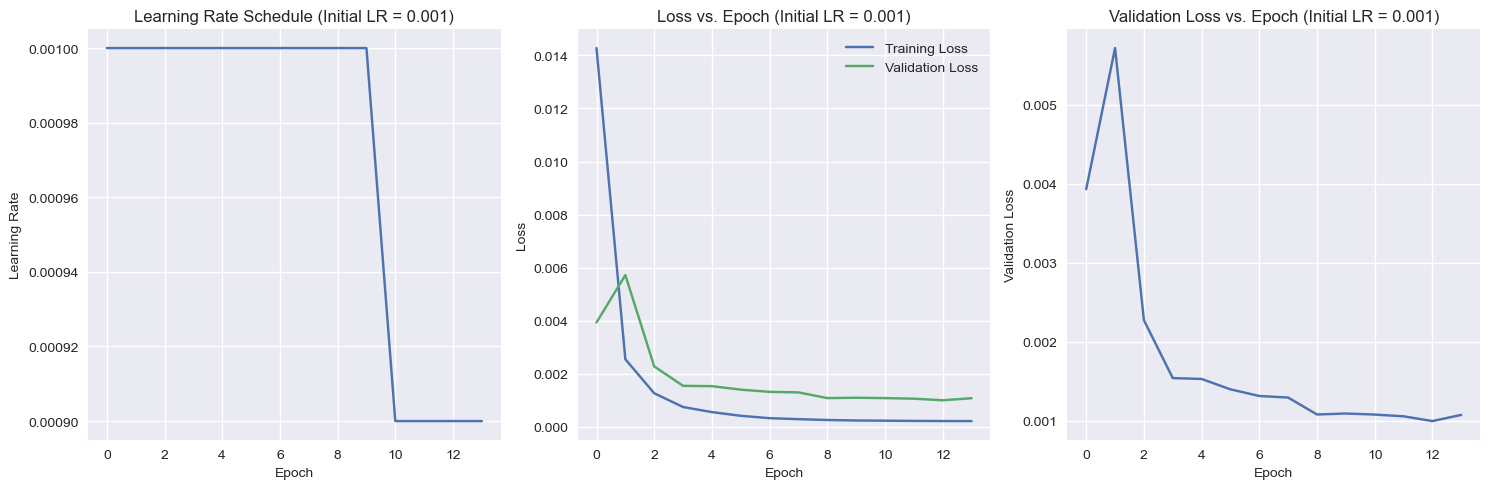

/Users/inderkaur/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop training after no improvement for 10 epochs
restore_best_weights=False,  # Restore the best weights when stopping
min_delta=0.0001)

checkpont_rnn = ModelCheckpoint(
    filepath='best_model',
    save_weights_only=False,
    save_freq = 'epoch',
    monitor = 'val_loss',
    mode='min',
    save_best_only = True,
    verbose = 1)

# Initialize lists to store loss and learning rates
losses = []
learning_rates = []

# Custom callback to log loss and learning rate
class LossLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        loss = logs['loss']
        learning_rates.append(lr)
#         print(learning_rates)
        losses.append(loss)
        print()
#         print(f"Learning Rate = {lr.numpy()}")
        print(f"Epoch {epoch+1}: Learning Rate = {lr.numpy()}, Loss = {loss}")
# 

# Create an instance of the custom callback
loss_lr_callback = LossLearningRateCallback()

def build_model(initial_lr=0.001):
    model_1 = Sequential([
    BatchNormalization(
        input_shape = (window_size,num_features),
        name = 'Batch_Norm_1'),
    LSTM(512,return_sequences=True,name='LSTM_1'),
    LSTM(512,name='LSTM_2'),
    Dense(256,activation='relu',name='Dense_1'),
    Dense(len(tickers),name='Returns')
])
    optimizer = Adam(learning_rate=initial_lr)
    
    model_1.compile(
    loss=tf.keras.losses.Huber(),
    metrics=[tf.metrics.RootMeanSquaredError(),'mae'],
    optimizer=optimizer)
    
    return model_1


def lr_schedule(epoch, initial_lr=0.01, decay_factor=0.9, decay_epochs=10):
    return initial_lr * (decay_factor ** (epoch // decay_epochs))

# learning schedule callback
lr_rate = LearningRateScheduler(lr_schedule)
# print(lr_rate.numpy())
callbacks_list = [lr_rate,loss_lr_callback, early_stopping, checkpont_rnn]
callbacks_list



# Define a list to store validation losses for each learning rate


# List of initial learning rates to try
initial_learning_rates = [0.001]

best_model = None
best_val_loss = float('inf')
validation_losses = []
num_epochs=100
for lr in initial_learning_rates:
    
    print(f"\nTraining with initial learning rate: {lr}")
    model_1 = build_model(initial_lr=lr)
    print(model_1.summary())

    history = model_1.fit(my_window.train,
                          epochs=num_epochs,
                          callbacks=callbacks_list,
                          verbose=1,
                          validation_data=my_window.val)
    
    # Get the final validation loss for this learning rate
    # Get the final validation loss for this learning rate
    final_val_loss = history.history['val_loss'][-1]
    validation_losses.append(final_val_loss)

    last_epoch = len(history.history['loss'])

# plt.plot(np.arange(1, last_epoch+1), history.history['loss'], label='Loss', lw=3)
# plt.plot(np.arange(1, last_epoch+1), history.history['val_loss'], label='val_loss', lw=3)


    # Plot learning rate vs. epoch
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(len(history.history['loss'])), [lr_schedule(i, initial_lr=lr) for i in range(len(history.history['loss']))])
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title(f'Learning Rate Schedule (Initial LR = {lr})')

    # Plot epoch vs. loss
    plt.subplot(1, 3, 2)
    plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training Loss')
    plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss vs. Epoch (Initial LR = {lr})')

    # Plot epoch vs. validation loss
    plt.subplot(1, 3, 3)
    plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss vs. Epoch (Initial LR = {lr})')

    plt.tight_layout()
    plt.show()
    
    # Check if this model has the best validation loss
    if final_val_loss < best_val_loss:
#         best_val_loss = final_val_loss
        best_lr = lr
        best_val_loss = final_val_loss
        best_model = model_1

# Save the best model
if best_model is not None:
    best_model.save('best_model.h5')


In [29]:
validation_losses

[0.0010744411265477538]

In [30]:
print(f'\nBest Learning Rate: {best_lr}, Best Validation Loss: {best_val_loss}')



Best Learning Rate: 0.001, Best Validation Loss: 0.0010744411265477538


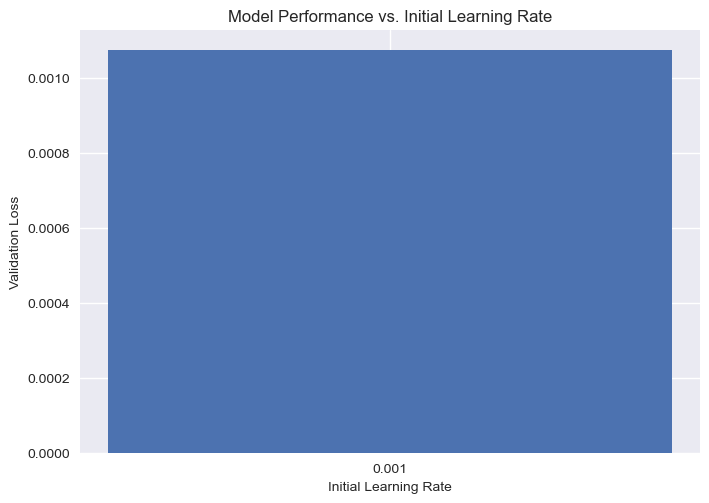

In [31]:
# Plot the performance of each initial learning rate
plt.bar([str(lr) for lr in initial_learning_rates], validation_losses)
plt.xlabel('Initial Learning Rate')
plt.ylabel('Validation Loss')
plt.title('Model Performance vs. Initial Learning Rate')
plt.show()

In [32]:
[str(lr) for lr in initial_learning_rates], validation_losses

(['0.001'], [0.0010744411265477538])

In [33]:
from tensorflow.keras.models import load_model

final_model = load_model('best_model.h5')

In [34]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Batch_Norm_1 (BatchNormali  (None, 5, 141)            564       
 zation)                                                         
                                                                 
 LSTM_1 (LSTM)               (None, 5, 512)            1339392   
                                                                 
 LSTM_2 (LSTM)               (None, 512)               2099200   
                                                                 
 Dense_1 (Dense)             (None, 256)               131328    
                                                                 
 Returns (Dense)             (None, 2)                 514       
                                                                 
Total params: 3570998 (13.62 MB)
Trainable params: 3570716 (13.62 MB)
Non-trainable params: 282 (1.10 KB)
________________

In [35]:
final_model.evaluate(my_window.test)

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 141), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 316ms/step - loss: 0.0014 - root_mean_squared_error: 0.0524 - mae: 0.0397


[0.0013726233737543225, 0.05239509791135788, 0.03974585235118866]

In [36]:
def plot_window(tickers,window_dataset,pandas_dataset,window_size,model,
                figsize=(12,50)):
    """This function plots the observed returns inside a tf.data.Dataset and
    compares them with the predicted returns of a model.

    Inputs:
    -------
    window_dataset (tensorflow.data.Dataset object): dataset with both inputs
        and target values.
    pandas_dataset (pandas DataFrame): dataframe that was used to create the
        window_dataset.
    window_size (int): window size used in the transformation from sequential 
        time series into window time series.
    model (model object): trained model with the capability to predict in a
        similar manner than tensorflow.keras.Model object.
    figsize (tuple, default=(12,100)): tuple with the dimensions of the figure
        where the data will be plotted.
    
    Ouputs:
    -------
    None
    """
    # Determine the X-axis of the plot:
    plot_index = pandas_dataset.iloc[window_size:,:].index

    # Assign in the addecuate format the values of the observed taget variable(s):
    y = np.concatenate([targets for inputs,targets in window_dataset],axis=0)
    
    # Use the model to predict the target variable(s):
    
    y_hat = model.predict(window_dataset)
    print("printing y hat of plot_window function")
    print(y_hat)
    # Adjust the shapes:
    y = y.reshape(y_hat.shape)
    print("printing y of plot_window function")
    print(y)

    # Plot the data:
    
#     for ticker in tickers:
#         print("&&&&&&&&&&&&&&&&&&")
#         print(ticker)
#         print(y_hat.shape[1])
    for n in range(y_hat.shape[1]):
        print(n)
        print(tickers[n])
        plt.figure(figsize=figsize)
        plt.subplot(y_hat.shape[1],1,n+1)
        plt.ylabel('Return')
        plt.plot(plot_index,y_hat[:,n],label='Predicted',color='maroon')
        plt.plot(plot_index,y[:,n],label='Observed',color='midnightblue',alpha=0.5)
        plt.title(tickers[n])
        plt.legend()

In [37]:
tickers[1]

'BIIB'

In [38]:
tickers

['DIS', 'BIIB']

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 141), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
6/6 [==============================] - 1s 62ms/step
printing y hat of plot_window function
[[ 0.05590042 -0.04086557]
 [ 0.04779839 -0.0459407 ]
 [ 0.03949258 -0.04021796]
 ...
 [ 0.00610381  0.02088739]
 [-0.00348131  0.01968847]
 [-0.00845499  0.01472772]]
printing y of plot_window function
[[ 3.71015351e-03  6.03539916e-03]
 [-4.54982650e-03  2.17211265e-02]
 [ 4.85631870e-03 -1.82223436e-03]
 ...
 [-8.68003466e-04  1.19247530e-02]
 [-1.54446636e-03 -3.18802631e-05]
 [-6.67059887e-03 -1.43644605e-02]]
0
DIS
1
BIIB


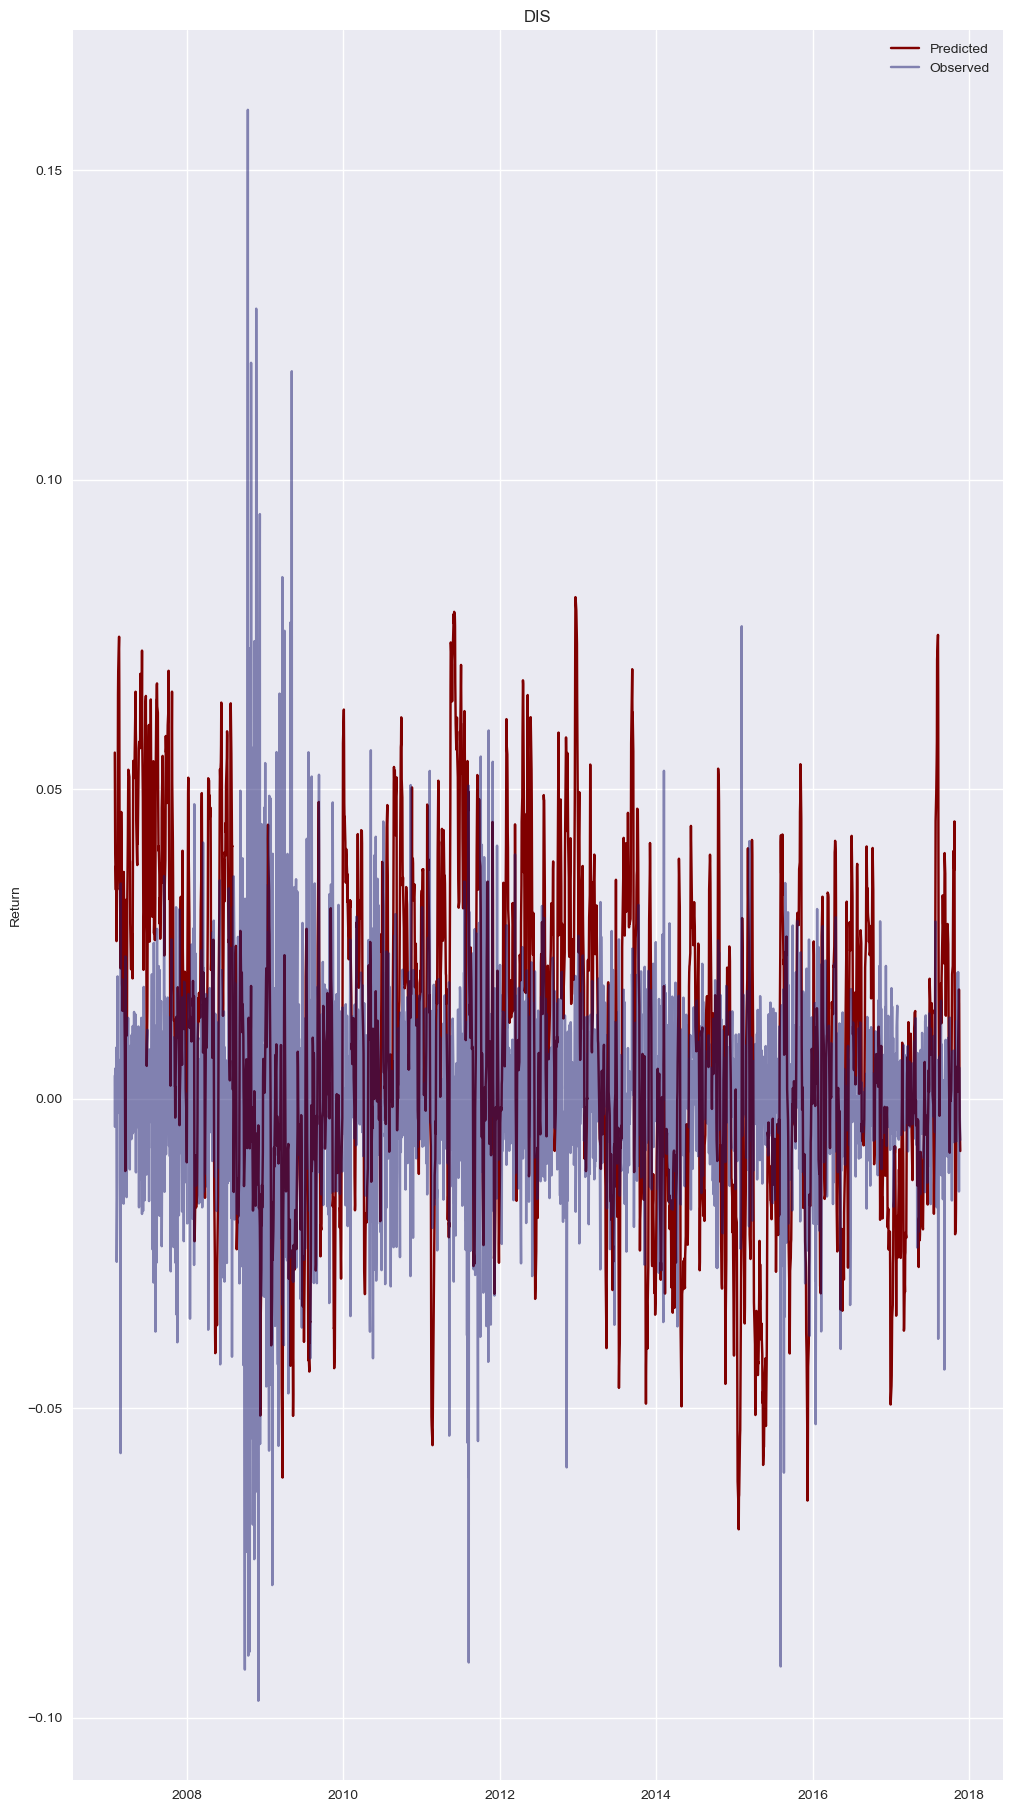

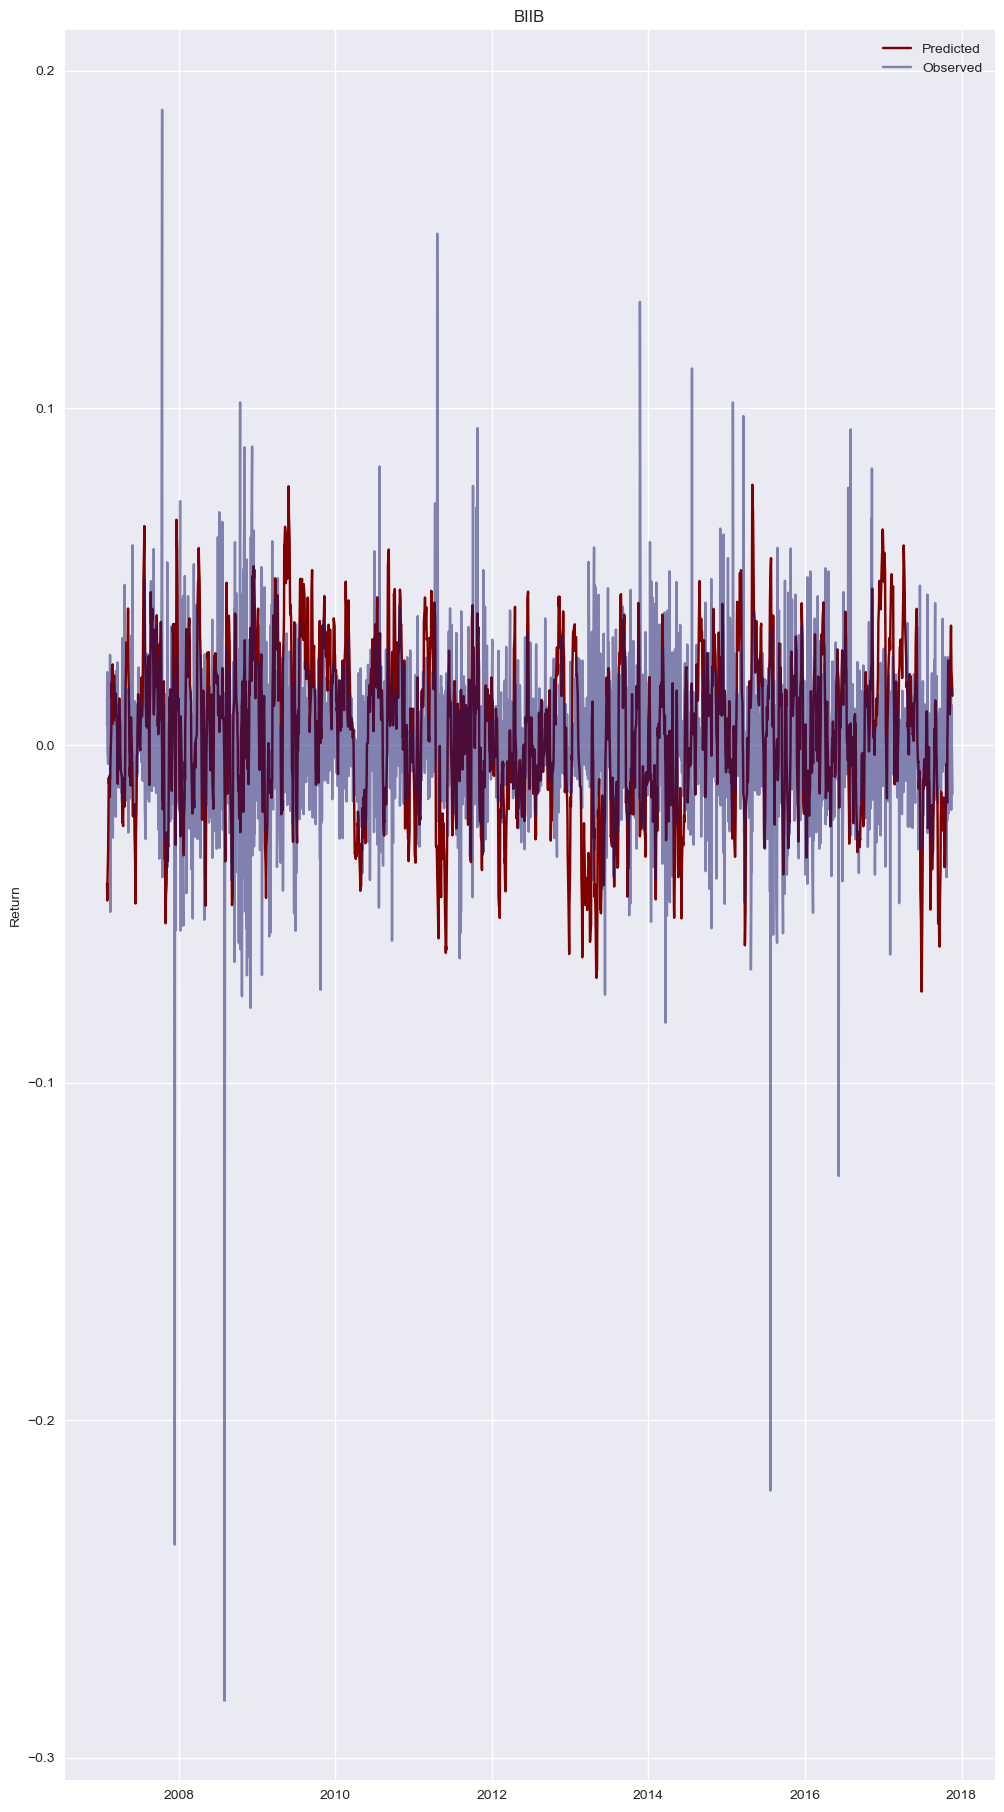

In [39]:
############# Training Results
# Create new WindowGenerator with the data not shuffled:
my_window_2 = WindowGenerator(
    input_width=window_size,
    label_width=1,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=label_cols,
    batch_size=batch_size,
    shuffle=False)

plot_window(tickers,my_window_2.train,train_df,window_size,final_model)

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 141), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 83ms/step
printing y hat of plot_window function
[[-1.26871988e-02  6.22900426e-02]
 [-1.22545473e-02  6.84103370e-02]
 [-1.14084817e-02  7.46399611e-02]
 [-2.17161775e-02  7.77667388e-02]
 [-3.23244557e-02  7.55575150e-02]
 [-4.06980179e-02  6.40145540e-02]
 [-3.21110450e-02  5.48569486e-02]
 [-2.53771357e-02  5.98053411e-02]
 [-1.92305893e-02  6.78705424e-02]
 [-1.66250318e-02  8.20964351e-02]
 [-7.96697661e-03  8.57265964e-02]
 [-2.61831284e-03  9.28833336e-02]
 [-2.05005333e-03  8.83359835e-02]
 [-2.91199610e-03  6.84725493e-02]
 [ 6.26549497e-03  4.39364314e-02]
 [ 1.13416277e-02  3.06704994e-02]
 [ 2.71729715e-02  2.56386306e-02]
 [ 4.46413942e-02  2.23479774e-02]
 [ 5.21360226e-02  3.00215539e-02]
 [ 5.21430634e-02  3.39894071e-02]
 [ 5.667

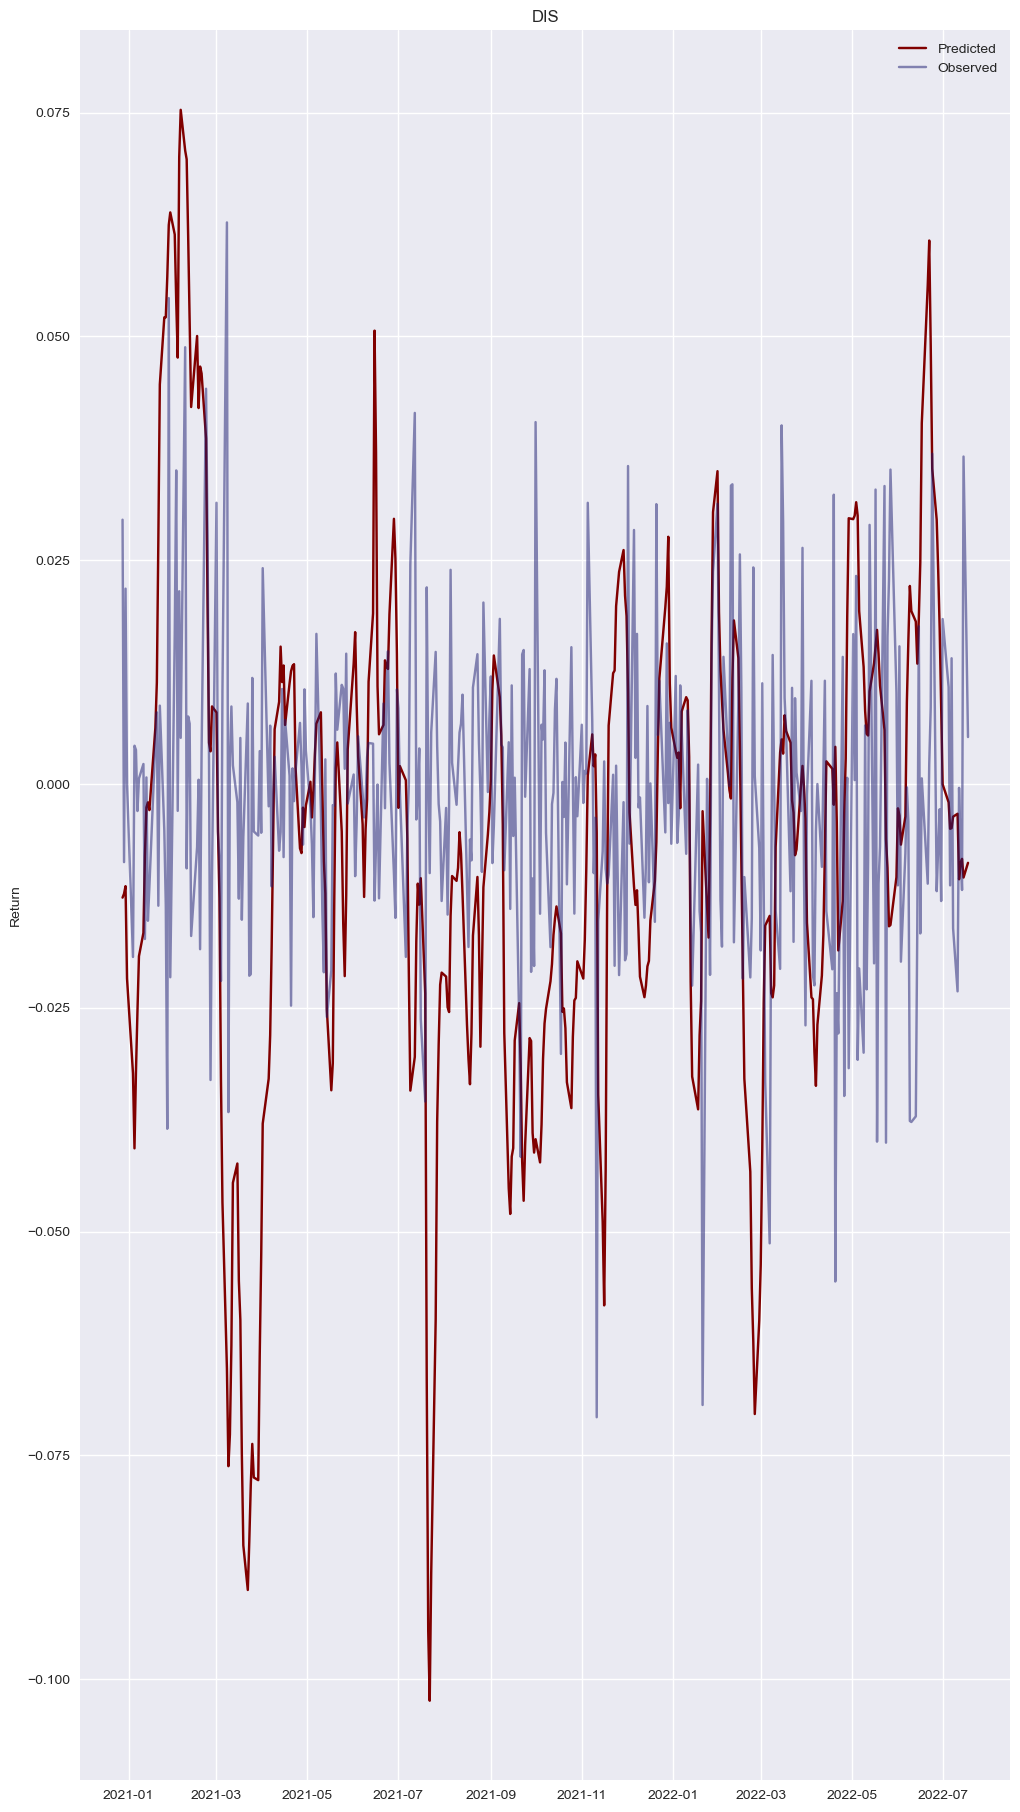

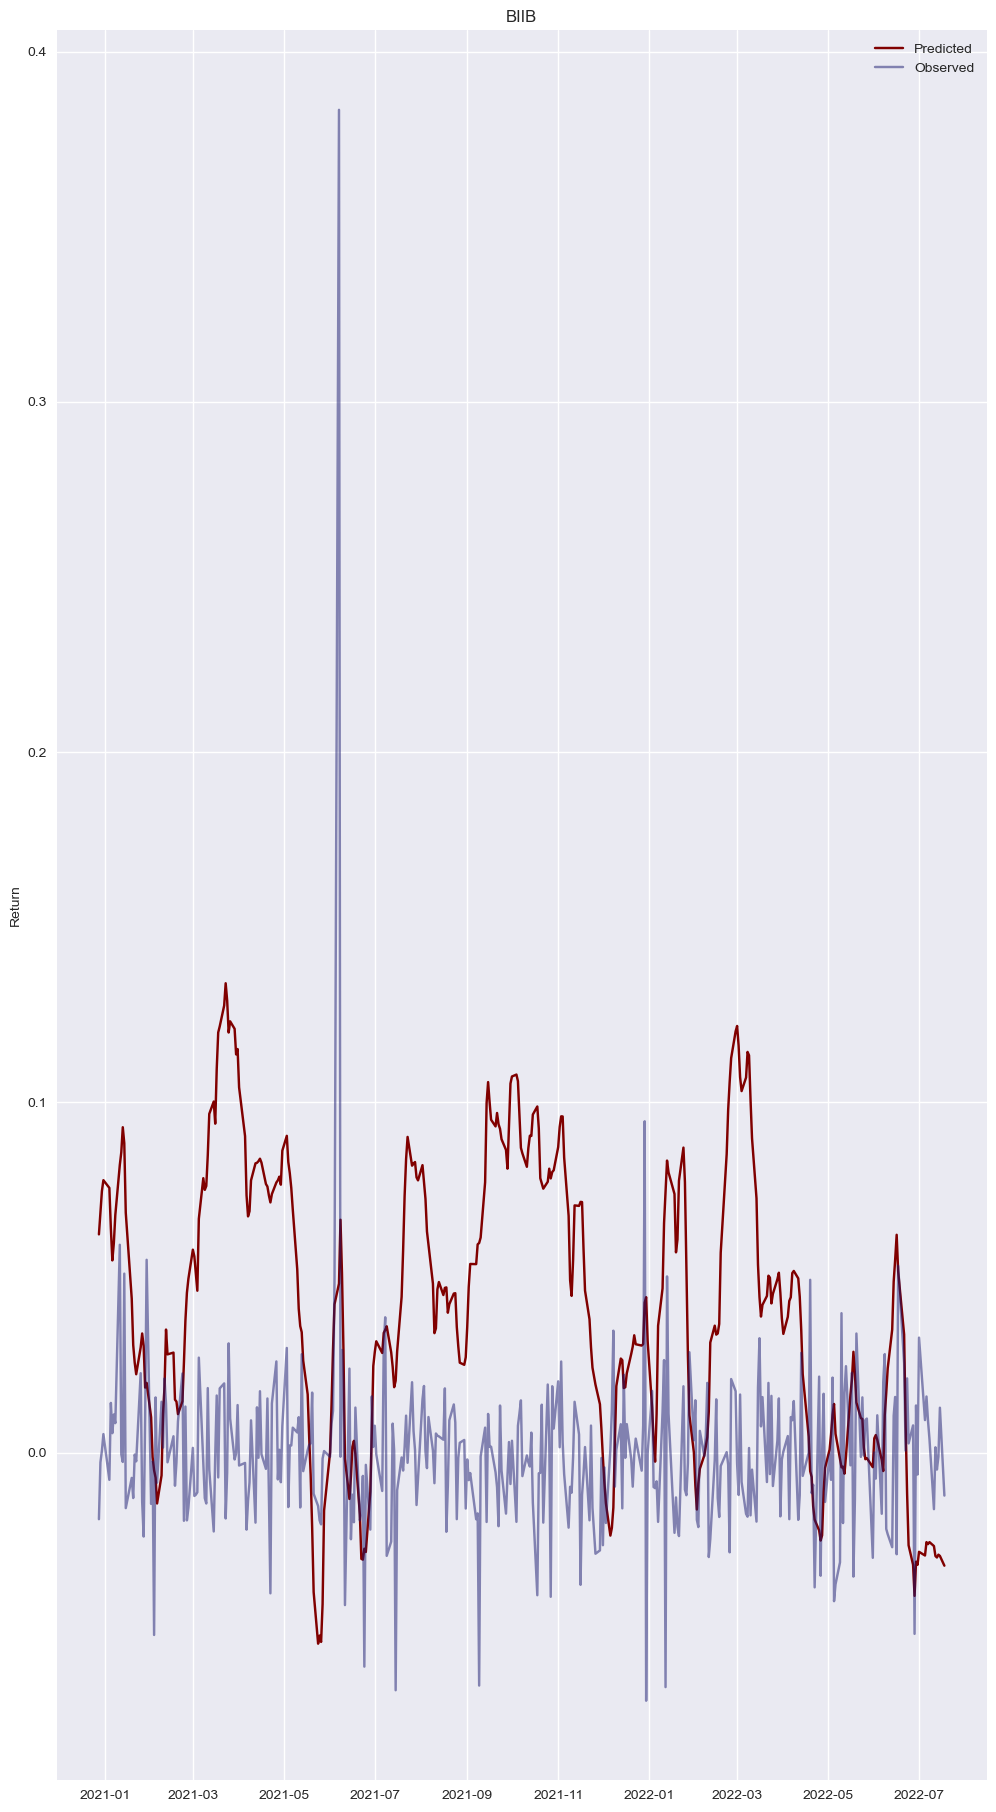

In [40]:
plot_window(tickers,my_window_2.test,test_df,window_size,final_model)

In [41]:
def optimize_portfolio(returns,guess_weights=None,rfr=0):
    """This function optimizes the weight allocation for the assets in a
    portfolio, represented by the returns.

    Inputs:
    -------
    returns (pandas DataFrame|Series): contains the returns information.
    guess_weights (list of numerical values, default=None): guess values for
        the weights of the different assets in the portfolio.
    short (boolena, default=True): define ifshort possitions are allowed or 
        not.
    rfr (numerical value, default=0): risk free rate, could be a series of
        the same length as returns.

    Outputs:
    --------
    opt_weights (array-like object): array with the optimal weights for the
        portfolio.
    """
    # Define important variables:
#     print("KIIIIIIII")
    num_assets = returns.shape[1]
    if isinstance(guess_weights,type(None)):
        guess_weights = [1/num_assets for i in range(num_assets)]

    # Define bound if short possitions are allowed or not:
    
    bounds = [(0,1) for i in range(num_assets)]
    

    # Define constraints, if there can or not be leverage
    weights_sum_to_1 = {'type':'eq',
                        'fun':lambda weights: np.sum(np.absolute(weights))-1}
#     print("sharpe ratio:::::::::::")
#     print(sharpe_ratio)
#     print("returns:::::::::::::::")
#     print(returns)
    # Minimize the function:
    opt_weights = spo.minimize(
        sharpe_ratio,
        guess_weights,
        args = (rfr, True, returns),
        method = 'SLSQP',
        options = {'disp':False},
        constraints = (weights_sum_to_1),
        bounds = bounds
    )

    return opt_weights 

In [42]:
def daily_rate(x, periods_year=252):
    """This function transforms a rate into a daily rate

    Inputs:
    -------
    x (numerical value): rate that you want to transform into a daily rate.
    periods_year (numerical value, default=252): amount of periods per year
        of the periodicity of rate x.
    
    Ouputs:
    -------
    df (numerical value): daily rate
    """
    dr = np.power(1+x,1/periods_year)-1
    return dr

In [43]:
def sharpe_ratio(weights=None, rfr=0, negative=False, returns=0):
    """Compute the Sharpe Ratio of a portfolio.

    Inputs:
    -------
    weights (list of numerical values, default=None): list with the weights
        of the assets in the portfolio.
    rfr (numerical value|array-like, default=0): risk-free rate.
    returns (pandas DataFrame|Series, default=0): returns of the assets in
        the portfolio.

    Outputs:
    --------
    sharpe_ratio (numerical value): Sharpe ratio of the portfolio.
    """
    # Define important variables:
    num_assets = returns.shape[1]
    if isinstance(weights,type(None)):
        weights = [1/num_assets for i in range(num_assets)]

    # Get portfolio returns:
    portfolio_returns = (returns*weights).sum(axis=1)
    portfolio_std = portfolio_returns.std()

    # Compute Sharpe Ratio formula:
    sharpe_ratio = (portfolio_returns-rfr).mean()/portfolio_std

    # If used in a minization process:
    if negative:
        sharpe_ratio *= -1

    return sharpe_ratio    

In [44]:
columns = ['FR_'+ticker for ticker in tickers]
y_train = final_model.predict(my_window_2.train)
y_val = final_model.predict(my_window_2.val)
y_test = final_model.predict(my_window_2.test)
y_hat_total = np.concatenate([y_train,y_val,y_test],axis=0)
ret_hat_df = pd.DataFrame(data=y_hat_total,index=model_data.index[5:],columns=columns)
rfr = data_quandl['3m_rate'].agg(daily_rate)
ret_hat_df = ret_hat_df.merge(rfr.rename('rfr'),left_index=True,right_index=True,
                             how='left')

opt_weights = np.array([optimize_portfolio(
    returns = window[ret_hat_df.columns[:-1]],
    rfr = window[ret_hat_df.columns[-1]]).x for window in ret_hat_df.rolling(40)])
opt_weights.shape

# opt_weights = np.array([optimize_portfolio(
#     returns=ret_hat_df[ret_hat_df.columns[:-1]],  # Exclude 'rfr' column
#     rfr=ret_hat_df['rfr']
# ).x])

# opt_weights = opt_weights.squeeze()  # Remove extra dimension if it exists

# Display the shape of opt_weights
print(f"Shape of optimized weights: {opt_weights.shape}")


************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 141), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
6/6 [==============================] - 0s 61ms/step
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 141), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
2/2 [==============================] - 0s 44ms/step
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 141), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 2), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 85ms/step
Shape of optimized weights: (3893, 2)


In [45]:
model_data.shape

(3898, 141)

In [46]:
opt_weights

array([[5.00000000e-01, 5.00000000e-01],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 6.84285961e-13],
       ...,
       [1.00000000e+00, 1.66533454e-16],
       [1.00000000e+00, 2.77555756e-17],
       [1.00000000e+00, 3.88578059e-16]])